In [1]:
#import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_df=pd.read_csv("01_data/soccer_results.csv")
#data_df.head(10)

In [3]:
#convert date to year/month/day
data_df['year']=pd.to_datetime(data_df['date']).dt.year
data_df['month']=pd.to_datetime(data_df['date']).dt.month
data_df['day']=pd.to_datetime(data_df['date']).dt.day
#data_df.head()

In [4]:
#define a function to determin winning team
def home_win_v2(home_away_list, flag):
    ''' Determine which if the home team wins the game by comparing home_score vs away_score
    
    INPUT:
    list of ['home_team','away_team','home_score','away_score']
    
    OUTPUT:

    if flag = 0
    2 - home win
    1 - tie
    0 - home lose

    if flag = 1
    name of the win team
    
    if flag = 2
    name of the lose team

    '''
    home_team = home_away_list[0]
    away_team = home_away_list[1]
    home_score = home_away_list[2]
    away_score = home_away_list[3]
    
    if home_score - away_score > 0:         # home team win
        return [2,home_team,away_team][flag]
    elif home_score - away_score == 0:      # tie
        return [1,"no_team","no_team"][flag]
    else:                                   # away team win
        return [0,away_team,home_team][flag]

In [5]:
#define a function to count winning rate

def game_stat(df, country_str, home_away_flag="overall"):

    ''' calculate the game statistics win/lose/tie
    
    
    INPUT: DaraFram,  country_name, home_away_flag="home","away","all"(default)
    
    OUTPUT: a tuple of (games_win, games_tie, games_lose)
    
    '''
    
    #select games
    
    if home_away_flag == "overall":
        data_count = df[(df['home_team'] == country_str) | (df['away_team'] == country_str)]
    elif home_away_flag == "home":
        data_count = df[df['home_team'] == country_str]
    else:
        data_count = df[df['away_team'] == country_str]
    
    # count win/lose/tie games
    games_win,games_lose,games_tie = 0,0,0
    if country_str in data_count['win_team'].value_counts().index:
        games_win = data_count['win_team'].value_counts()[country_str]
    if country_str in data_count['lose_team'].value_counts().index:
        games_lose = data_count['lose_team'].value_counts()[country_str]
    if 'no_team' in data_count['lose_team'].value_counts().index:
        games_tie = data_count['win_team'].value_counts()['no_team']
    
    if((games_win + games_tie + games_lose) == 0):
        return (0,0,0,0)
    else:
        winning_rate = games_win/(games_win + games_tie + games_lose)
        return (games_win, games_tie, games_lose, winning_rate)
    #print(games_win, games_lose, games_tie)


In [6]:
#list out win_team and lose team
data_df['home_win_flag'] = data_df[['home_team','away_team','home_score','away_score']].apply(home_win_v2, args=(0,), axis=1)
data_df['win_team'] = data_df[['home_team','away_team','home_score','away_score']].apply(home_win_v2, args=(1,), axis=1)
data_df['lose_team'] = data_df[['home_team','away_team','home_score','away_score']].apply(home_win_v2, args=(2,), axis=1)
#data_df.head(10)
#data_df.shape

In [7]:
#only select the last 100 year results
result_100yr = data_df[data_df['year']>=1920].copy()

In [8]:
#choose the first 100 teams in both home and away save a data as df_result_interest
home_teams_100 = set(result_100yr['home_team'].value_counts().index[:100])
away_teams_100 = set(result_100yr['away_team'].value_counts().index[:100])
teams_interest = home_teams_100.intersection(away_teams_100)
df_result_interest = result_100yr[(result_100yr['home_team'].isin(teams_interest)) & (result_100yr['away_team'].isin(teams_interest))]

In [9]:
# for each county compute the statistics of the results within a period

def game_summary(df, country_list, f_year=1920, l_year=2020):

    '''
    for each country create game  summary win/lose/tie/win_rate of overall/home/away
    
    INPUT: DataFram, country_list, f_year=1990, l_year=2020 
            data, the list of country, first/last year for the summary
            
    OUTPUT: DataFram with 5 columns country, Win, Tie, Lose, Win_rate, home_away


    '''

    #count winning rate rank in overall/home/away
    results_all = pd.DataFrame(columns=['Win',"Tie","Lose","Win_rate"])
    results_home = pd.DataFrame(columns=['Win',"Tie","Lose","Win_rate"])
    results_away = pd.DataFrame(columns=['Win',"Tie","Lose","Win_rate"])
    
    for country in country_list:
        results_all.loc[country] = game_stat(df[(df['year']>=f_year) & (df['year']<=l_year)], country, "overall")
        results_home.loc[country] = game_stat(df[(df['year']>=f_year) & (df['year']<=l_year)], country, "home")
        results_away.loc[country] = game_stat(df[(df['year']>=f_year) & (df['year']<=l_year)], country, "away")

    results_all['home_away'] = 'overall'
    results_home['home_away'] = 'home'
    results_away['home_away'] = 'away'

    object_results_all = results_all[results_all.index.isin(country_list)]
    object_results_home = results_home[results_home.index.isin(country_list)]
    object_results_away = results_away[results_away.index.isin(country_list)]
    
    out_df=pd.concat([object_results_all, object_results_home, object_results_away])
    out_df.reset_index(inplace=True)
    out_df.rename(columns={"index":"Country"},inplace=True)
    
    return out_df


In [10]:
# for each county compute the statistics of the mutual game results within a period


def game_summary_mutual(df, country_list, f_year=1920, l_year=2020):

    '''
    for each country create game summary win/lose/tie/win_rate of overall/home/away
    only consider games that played within these countries
    
    INPUT: DataFram, country_list, f_year=1990, l_year=2020 
            data, the list of country, first/last year for the summary
            
    OUTPUT: DataFram with 5 columns country, Win, Tie, Lose, Win_rate, home_away


    '''

    #count winning rate rank in overall/home/away
    results_all = pd.DataFrame(columns=['Win',"Tie","Lose","Win_rate"])
    results_home = pd.DataFrame(columns=['Win',"Tie","Lose","Win_rate"])
    results_away = pd.DataFrame(columns=['Win',"Tie","Lose","Win_rate"])
    
    df_mut = df[(df['home_team'].isin(country_list)) & (df['away_team'].isin(country_list))]
    
    for country in country_list:
        results_all.loc[country] = game_stat(df_mut[(df_mut['year']>=f_year) & (df_mut['year']<=l_year)], country, "overall")
        results_home.loc[country] = game_stat(df_mut[(df_mut['year']>=f_year) & (df_mut['year']<=l_year)], country, "home")
        results_away.loc[country] = game_stat(df_mut[(df_mut['year']>=f_year) & (df_mut['year']<=l_year)], country, "away")

    results_all['home_away'] = 'overall'
    results_home['home_away'] = 'home'
    results_away['home_away'] = 'away'

    object_results_all = results_all[results_all.index.isin(country_list)]
    object_results_home = results_home[results_home.index.isin(country_list)]
    object_results_away = results_away[results_away.index.isin(country_list)]
    
    out_df=pd.concat([object_results_all, object_results_home, object_results_away])
    out_df.reset_index(inplace=True)
    out_df.rename(columns={"index":"Country"},inplace=True)
    
    return out_df

In [11]:
# define a function to compute the score summary

def score_summary(df, country_list, f_year=1920, l_year=2020):

    '''
    for each country create score summary in home/away, average GF(scored)/game 
    and GA(average scored by opponent)/game
    
    INPUT: DataFram, country_list, f_year=1990, l_year=2020 
            data, the list of country, first/last year for the summary
            
    OUTPUT: DataFram with 7 columns country, home_GF, away_GF, home_GA, away_GA, overall_GF, overall_GA
    '''
    
    df_count = df[(df['year']>=f_year) & (df['year']<=l_year)]
    
    score_df = pd.DataFrame(columns=['home_GF',"away_GF","home_GA","away_GA","overall_GF", "overall_GA"])
    
    for country in country_list:
        home_gf_ave = df_count[df_count['home_team'] == country]['home_score'].mean()
        home_ga_ave = df_count[df_count['home_team'] == country]['away_score'].mean()
        away_gf_ave = df_count[df_count['away_team'] == country]['away_score'].mean()
        away_ga_ave = df_count[df_count['away_team'] == country]['home_score'].mean()
        home_games = df_count[df_count['home_team'] == country].shape[0]
        away_games = df_count[df_count['away_team'] == country].shape[0]
        overall_gf_ave = (home_gf_ave * home_games + away_gf_ave * away_games)/(home_games + away_games)
        overall_ga_ave = (home_ga_ave * home_games + away_ga_ave * away_games)/(home_games + away_games)
        score_df.loc[country] = (home_gf_ave, away_gf_ave, home_ga_ave, away_ga_ave, overall_gf_ave, overall_ga_ave)
    
    score_df.reset_index(inplace=True)
    score_df.rename(columns={"index":"Country"},inplace=True)
    
    return score_df

In [12]:
# list out the top 20 country with best winning rate
total_summary = game_summary(df_result_interest,teams_interest)
top_20_country = total_summary.sort_values(by='Win_rate', ascending = False)['Country'].iloc[:20]

In [13]:
top20_summary = game_summary(df_result_interest,top_20_country)

In [14]:
# prep base color for plot
base_color=sns.color_palette()[0]
plt.rcParams["figure.figsize"] = [12,6]

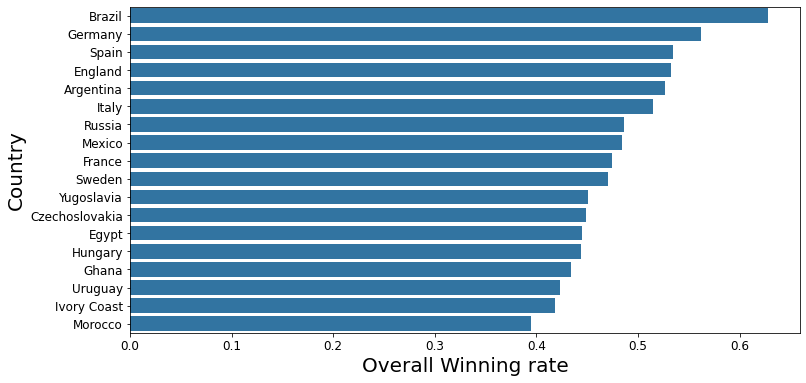

In [15]:
# calculate top20 winning rate
rank_order = list(top20_summary[top20_summary['home_away']=='overall'].sort_values(by=['Win_rate'], ascending=False)['Country'])
sns.barplot(data=top20_summary[top20_summary['home_away'] == 'overall'], 
            x='Win_rate', y='Country', order = rank_order, color=base_color)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel('Overall Winning rate', fontsize=20);
plt.ylabel('Country', fontsize=20);

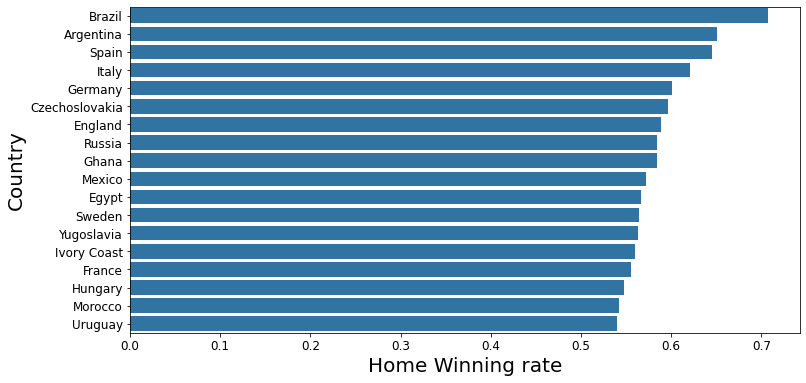

In [16]:
# calculate top20 home winning rate
rank_order = list(top20_summary[top20_summary['home_away'] == 'home'].sort_values(by='Win_rate',ascending=False)['Country'])

sns.barplot(data=top20_summary[top20_summary['home_away'] == 'home'], 
            x='Win_rate', y='Country', order = rank_order, color=base_color)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel('Home Winning rate', fontsize=20);
plt.ylabel('Country', fontsize=20);

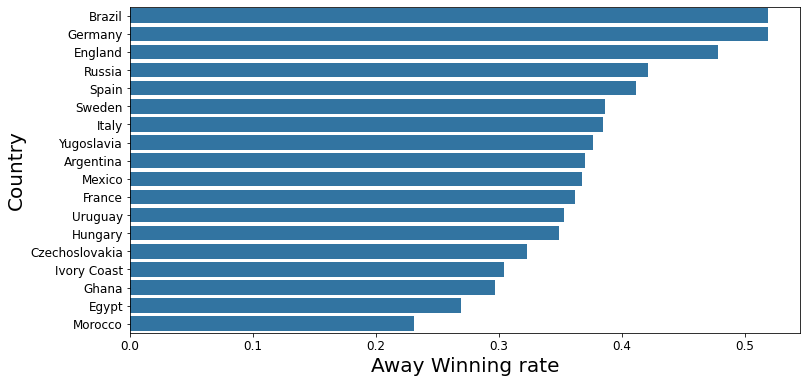

In [17]:
# calculate top20 away winning rate
rank_order = list(top20_summary[top20_summary['home_away'] == 'away'].sort_values(by='Win_rate',ascending=False)['Country'])

sns.barplot(data=top20_summary[top20_summary['home_away'] == 'away'], 
            x='Win_rate', y='Country', order = rank_order, color=base_color)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel('Away Winning rate', fontsize=20);
plt.ylabel('Country', fontsize=20);

In [18]:
# calculate score statistics for the top 20 country
top_20_score = score_summary(df_result_interest,top_20_country)

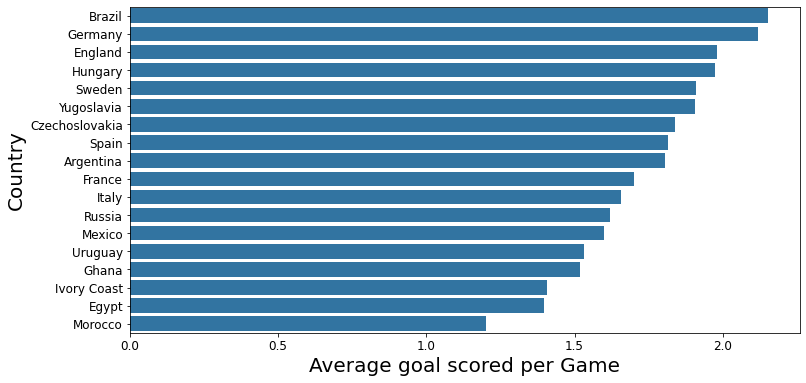

In [19]:
#plot score per game

rank_order = list(top_20_score.sort_values(by='overall_GF', ascending = False)['Country'])

sns.barplot(data=top_20_score, x='overall_GF', y='Country', order = rank_order, color=base_color)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel('Average goal scored per Game', fontsize=20);
plt.ylabel('Country', fontsize=20);

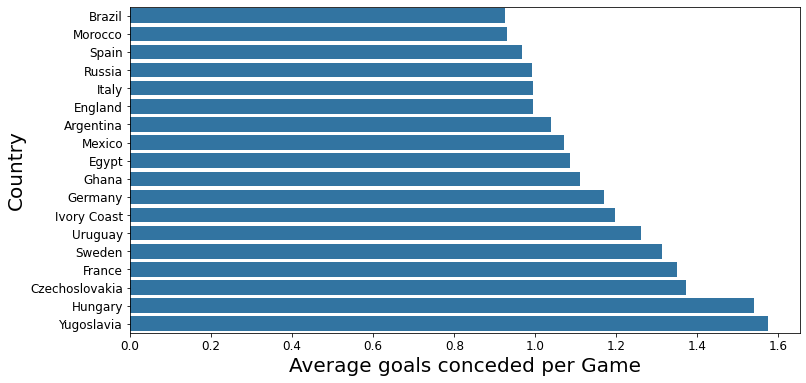

In [20]:
# plot scored by opponent per game

rank_order = list(top_20_score.sort_values(by='overall_GA')['Country'])

sns.barplot(data=top_20_score, x='overall_GA', y='Country', order = rank_order, color=base_color)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel('Average goals conceded per Game', fontsize=20);
plt.ylabel('Country', fontsize=20);

In [21]:
#calculate average goal of home team, away team and total
home_scores_ave = df_result_interest.groupby('year').mean()['home_score']
away_scores_ave = df_result_interest.groupby('year').mean()['away_score']
total_scores_ave = home_scores_ave + away_scores_ave

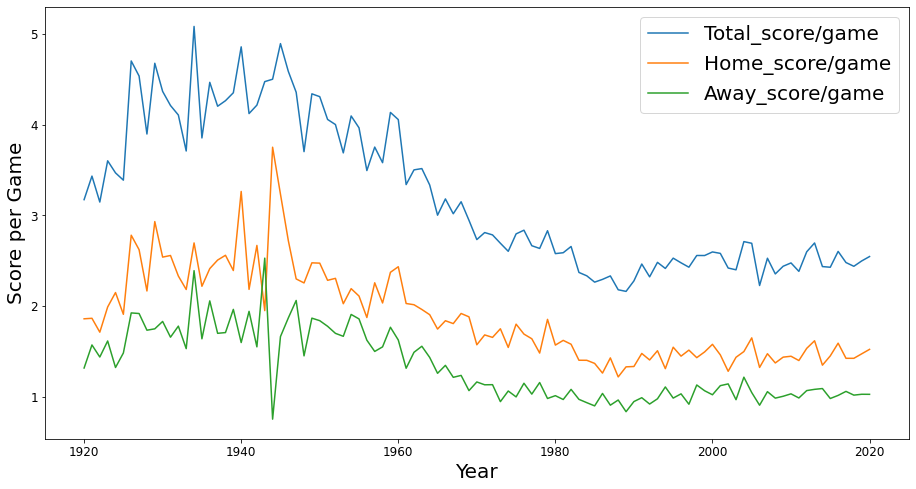

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(total_scores_ave.index, total_scores_ave, label = 'Total_score/game')
ax.plot(home_scores_ave.index, home_scores_ave, label = 'Home_score/game')
ax.plot(away_scores_ave.index, away_scores_ave, label = 'Away_score/game')
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel('Year', fontsize=20);
plt.ylabel('Score per Game', fontsize=20);
ax.legend(loc=0,prop={'size': 20})

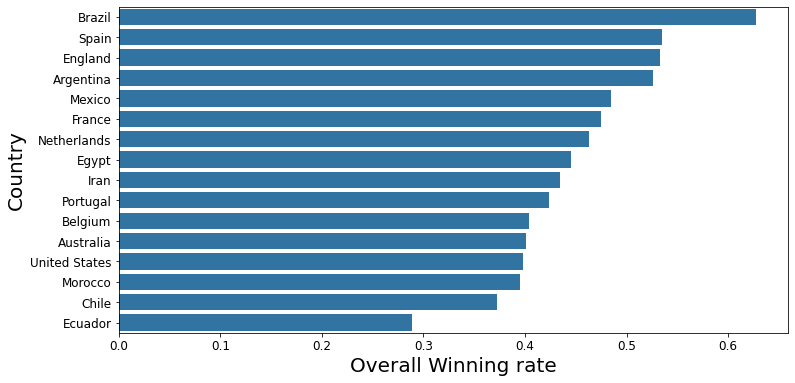

In [23]:
# list out the top 20 country with best winning rate in the last 20 years
total_summary = game_summary(df_result_interest,teams_interest,f_year=2000,l_year=2020)
top_20_country = total_summary.sort_values(by='Win_rate', ascending = False)['Country'].iloc[:20]
top20_summary = game_summary(df_result_interest,top_20_country)
# calculate top20 winning rate
rank_order = list(top20_summary[top20_summary['home_away']=='overall'].sort_values(by=['Win_rate'], ascending=False)['Country'])
sns.barplot(data=top20_summary[top20_summary['home_away'] == 'overall'], 
            x='Win_rate', y='Country', order = rank_order, color=base_color)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel('Overall Winning rate', fontsize=20);
plt.ylabel('Country', fontsize=20);

In [30]:
total_summary[total_summary['Country']=="Italy"]
print(f"total: {total_scores_ave.iloc[-10:].mean()}")
print(f"home: {home_scores_ave.iloc[-10:].mean()}")
print(f"away: {away_scores_ave.iloc[-10:].mean()}")

total: 2.508395751224163
home: 1.4757893979908947
away: 1.0326063532332679
